Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found 46646 files belonging to 6 classes.
Found 9993 files belonging to 6 classes.
Found 10001 files belonging to 6 classes.


Extracting ViT features (HSV): 100%|██████████| 313/313 [03:50<00:00,  1.36it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


I0000 00:00:1753219636.209104     105 service.cc:148] XLA service 0x7be7540173c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753219636.209708     105 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  75/1458 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5446 - loss: 1.5092

I0000 00:00:1753219637.248363     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1458/1458 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8562 - loss: 0.8009 - val_accuracy: 0.9792 - val_loss: 0.5060 - learning_rate: 0.0010
Epoch 2/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9717 - loss: 0.5552 - val_accuracy: 0.9815 - val_loss: 0.4904 - learning_rate: 0.0010
Epoch 3/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9805 - loss: 0.5288 - val_accuracy: 0.9843 - val_loss: 0.4828 - learning_rate: 0.0010
Epoch 4/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9837 - loss: 0.5211 - val_accuracy: 0.9858 - val_loss: 0.4732 - learning_rate: 0.0010
Epoch 5/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9850 - loss: 0.5152 - val_accuracy: 0.9868 - val_loss: 0.4713 - learning_rate: 0.0010
Epoch 6/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9870 - loss: 0.5077 - val_accuracy: 0.9864 - val_loss: 0.4675 - learning_rate: 0.0010
Epoch 7/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9897 - loss: 0.5016

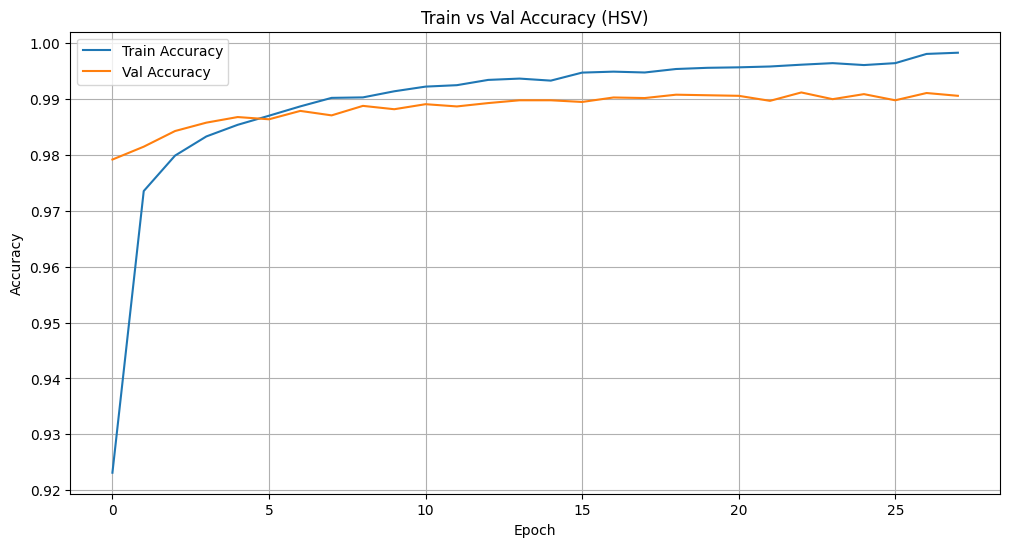

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.4625
Test Loss (HSV): 0.4551, Test Accuracy (HSV): 0.9906
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


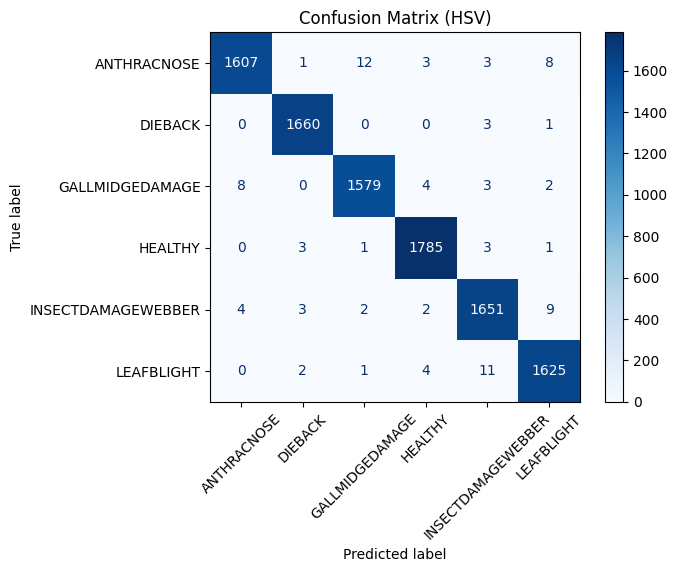

Classification Report (HSV):
                     precision    recall  f1-score   support

       ANTHRACNOSE     0.9926    0.9835    0.9880      1634
           DIEBACK     0.9946    0.9976    0.9961      1664
   GALLMIDGEDAMAGE     0.9900    0.9893    0.9897      1596
           HEALTHY     0.9928    0.9955    0.9942      1793
INSECTDAMAGEWEBBER     0.9863    0.9880    0.9871      1671
        LEAFBLIGHT     0.9872    0.9890    0.9881      1643

          accuracy                         0.9906     10001
         macro avg     0.9906    0.9905    0.9905     10001
      weighted avg     0.9906    0.9906    0.9906     10001



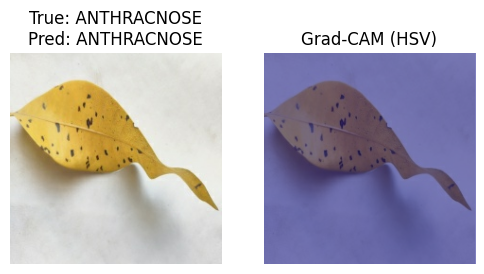

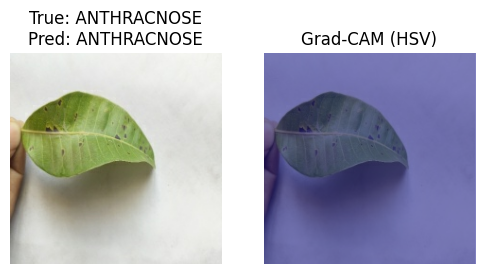

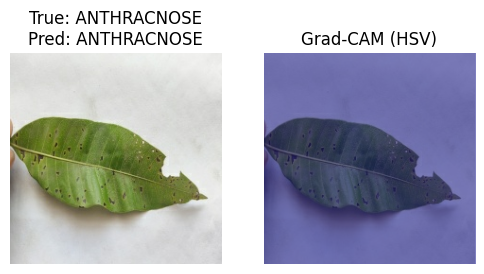

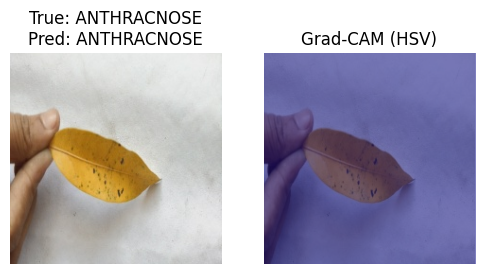

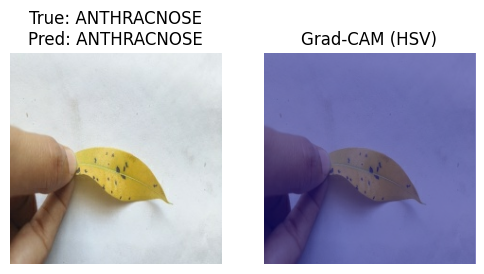

In [3]:
import tensorflow as tf
from transformers import ViTFeatureExtractor, TFAutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import cv2
import os

# ==========================================
# ✅ CONFIGURATION
# ==========================================
COLOR_SPACE = "HSV"  # Options: "RGB", "HSV", "LAB", "YCbCr"
img_size = (224, 224)
batch_size = 32
num_classes = 6

# ==========================================
# ✅ COLOR CONVERSION FUNCTION
# ==========================================
def convert_color_space(image_batch):
    image_batch = image_batch.astype(np.uint8)  # 🔁 Removed `.numpy()`
    converted_batch = []
    for img in image_batch:
        if COLOR_SPACE == "HSV":
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif COLOR_SPACE == "LAB":
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif COLOR_SPACE == "YCbCr":
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        converted_batch.append(img)
    return np.array(converted_batch)

# ==========================================
# ✅ LOAD ViT & FEATURE EXTRACTOR
# ==========================================
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_model = TFAutoModel.from_pretrained('google/vit-base-patch16-224')
vit_model.trainable = False

# ==========================================
# ✅ DATASET LOADING
# ==========================================
train_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/train'
val_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/val'
test_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/test'

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=img_size, batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=img_size, batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=img_size, batch_size=batch_size, shuffle=False)

class_names = train_ds.class_names

# ==========================================
# ✅ FEATURE EXTRACTION FUNCTION
# ==========================================
def extract_features(dataset):
    all_features, all_labels = [], []
    for batch_images, batch_labels in tqdm(dataset, desc=f"Extracting ViT features ({COLOR_SPACE})"):
        if COLOR_SPACE != "RGB":
            images_converted = tf.numpy_function(convert_color_space, [batch_images], tf.uint8)
            images_converted = tf.cast(images_converted, tf.uint8)
        else:
            images_converted = tf.image.convert_image_dtype(batch_images, dtype=tf.uint8)
        images_np = images_converted.numpy()
        pixel_values = feature_extractor(images_np, return_tensors='tf')['pixel_values']
        outputs = vit_model(pixel_values, training=False)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
        all_features.append(cls_embeddings.numpy())
        all_labels.append(batch_labels.numpy())
    features = np.vstack(all_features)
    labels = tf.keras.utils.to_categorical(np.concatenate(all_labels), num_classes)
    return features, labels

# ==========================================
# ✅ EXTRACT FEATURES
# ==========================================
X_train, y_train = extract_features(train_ds)
X_val, y_val = extract_features(val_ds)
X_test, y_test = extract_features(test_ds)

# ==========================================
# ✅ CLASSIFIER HEAD
# ==========================================
classifier = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

classifier.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint(f'best_vit_head_{COLOR_SPACE}.keras', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# ==========================================
# ✅ TRAINING
# ==========================================
history = classifier.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=callbacks)

# Save model
classifier.save(f'final_vit_head_model_{COLOR_SPACE}.keras')
classifier.save(f'final_vit_head_model_{COLOR_SPACE}.h5')

# Accuracy plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.grid(True)
plt.title(f'Train vs Val Accuracy ({COLOR_SPACE})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# ==========================================
# ✅ TEST RESULTS
# ==========================================
test_loss, test_acc = classifier.evaluate(X_test, y_test)
print(f"Test Loss ({COLOR_SPACE}): {test_loss:.4f}, Test Accuracy ({COLOR_SPACE}): {test_acc:.4f}")

# Confusion Matrix
y_pred_probs = classifier.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title(f"Confusion Matrix ({COLOR_SPACE})")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(f"Classification Report ({COLOR_SPACE}):\n", report)
with open(f"classification_report_vit_{COLOR_SPACE}.txt", "w") as f:
    f.write(report)

# ==========================================
# ✅ GRAD-CAM VISUALIZATION
# ==========================================
def preprocess_for_vit(img_batch):
    if COLOR_SPACE != "RGB":
        img_batch = tf.numpy_function(convert_color_space, [img_batch], tf.uint8)
    img_batch_uint8 = tf.image.convert_image_dtype(img_batch, dtype=tf.uint8)
    return feature_extractor(img_batch_uint8.numpy(), return_tensors='tf')['pixel_values']

def get_grad_cam_heatmap(image, classifier_model):
    with tf.GradientTape() as tape:
        pixel_values = preprocess_for_vit(image[None])[0]
        vit_out = vit_model(pixel_values[None], training=False).last_hidden_state  # shape: (1, 197, 768)
        cls_token = vit_out[:, 0, :]  # (1, 768)

        tape.watch(cls_token)
        preds = classifier_model(cls_token)
        top_class = tf.argmax(preds[0])
        top_output = preds[:, top_class]

    grads = tape.gradient(top_output, cls_token)
    pooled_grads = tf.reduce_mean(grads, axis=1)
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, cls_token), axis=1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()[0], int(top_class)

def display_gradcam(image, heatmap, true_label, pred_label, class_names):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(tf.cast(image, tf.uint8))
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(tf.cast(image, tf.uint8))
    plt.imshow(heatmap.reshape((1, 1)), cmap='jet', alpha=0.5, extent=(0, 224, 224, 0))
    plt.title(f"Grad-CAM ({COLOR_SPACE})")
    plt.axis("off")
    plt.show()

# ==========================================
# ✅ LOAD TEST IMAGES FOR VISUALIZATION
# ==========================================
raw_test_images, raw_labels = [], []
for batch_images, batch_labels in test_ds.take(1):
    raw_test_images.append(batch_images)
    raw_labels.append(batch_labels)

raw_test_images = tf.concat(raw_test_images, axis=0)
raw_labels = tf.concat(raw_labels, axis=0)

# ==========================================
# ✅ RUN GRAD-CAM FOR FIRST 5 IMAGES
# ==========================================
for i in range(5):
    image = raw_test_images[i]
    true_label = int(raw_labels[i])
    heatmap, pred_label = get_grad_cam_heatmap(image, classifier)
    display_gradcam(image, heatmap, true_label, pred_label, class_names)



/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.poo

Found 46646 files belonging to 6 classes.
Found 9993 files belonging to 6 classes.
Found 10001 files belonging to 6 classes.


Extracting ViT features (LAB): 100%|██████████| 313/313 [03:50<00:00,  1.36it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8646 - loss: 0.7840 - val_accuracy: 0.9860 - val_loss: 0.4900 - learning_rate: 0.0010
Epoch 2/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9835 - loss: 0.5297 - val_accuracy: 0.9882 - val_loss: 0.4736 - learning_rate: 0.0010
Epoch 3/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9868 - loss: 0.5141 - val_accuracy: 0.9906 - val_loss: 0.4649 - learning_rate: 0.0010
Epoch 4/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9910 - loss: 0.4993 - val_accuracy: 0.9904 - val_loss: 0.4622 - learning_rate: 0.0010
Epoch 5/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9930 - loss: 0.4924 - val_accuracy: 0.9936 - val_loss: 0.4573 - learning_rate: 0.0010
Epoch 6/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9930 - loss: 0.4889 - val_accuracy: 0.9916 - val_loss: 0.4587 - learning_rate: 0.0010
Epoch 7/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9936 - l

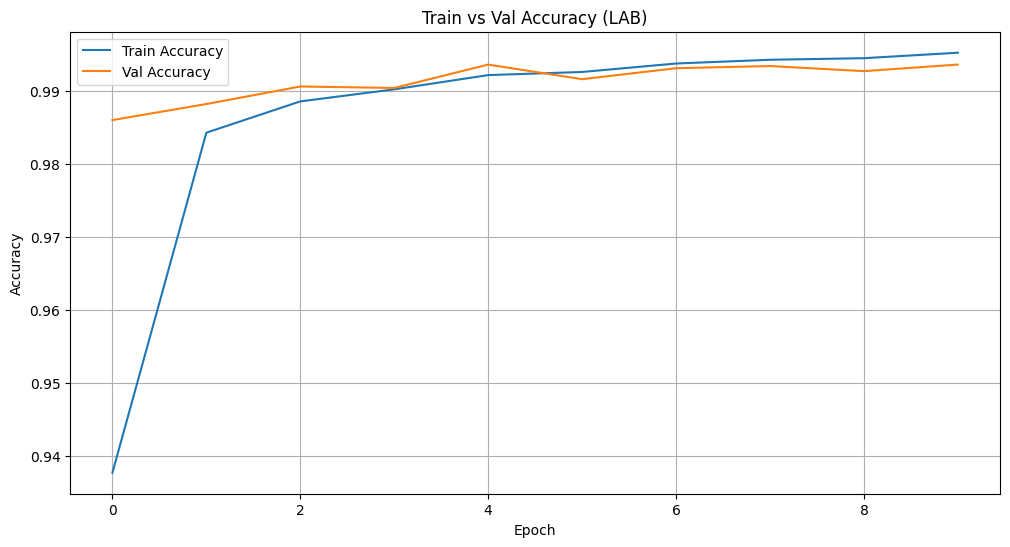

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9896 - loss: 0.4650
Test Loss (LAB): 0.4567, Test Accuracy (LAB): 0.9926
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


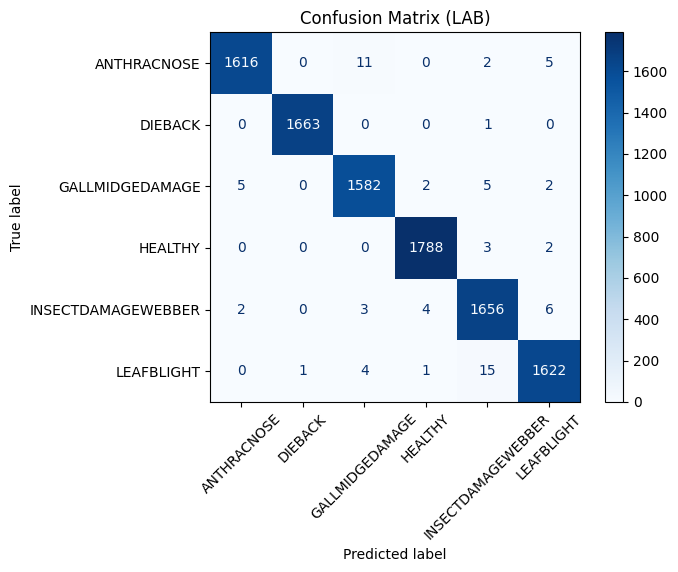

Classification Report (LAB):
                     precision    recall  f1-score   support

       ANTHRACNOSE     0.9957    0.9890    0.9923      1634
           DIEBACK     0.9994    0.9994    0.9994      1664
   GALLMIDGEDAMAGE     0.9888    0.9912    0.9900      1596
           HEALTHY     0.9961    0.9972    0.9967      1793
INSECTDAMAGEWEBBER     0.9845    0.9910    0.9878      1671
        LEAFBLIGHT     0.9908    0.9872    0.9890      1643

          accuracy                         0.9926     10001
         macro avg     0.9926    0.9925    0.9925     10001
      weighted avg     0.9926    0.9926    0.9926     10001



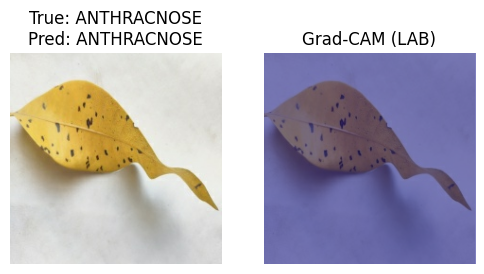

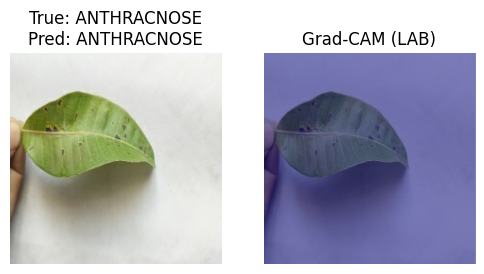

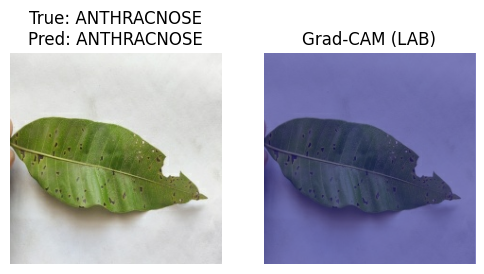

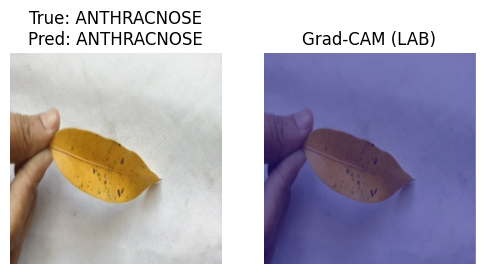

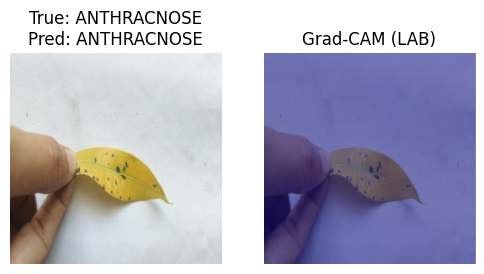

In [4]:
import tensorflow as tf
from transformers import ViTFeatureExtractor, TFAutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import cv2
import os

# ==========================================
# ✅ CONFIGURATION
# ==========================================
COLOR_SPACE = "LAB"  # Options: "RGB", "HSV", "LAB", "YCbCr"
img_size = (224, 224)
batch_size = 32
num_classes = 6

# ==========================================
# ✅ COLOR CONVERSION FUNCTION
# ==========================================
def convert_color_space(image_batch):
    image_batch = image_batch.astype(np.uint8)  # 🔁 Removed `.numpy()`
    converted_batch = []
    for img in image_batch:
        if COLOR_SPACE == "HSV":
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif COLOR_SPACE == "LAB":
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif COLOR_SPACE == "YCbCr":
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        converted_batch.append(img)
    return np.array(converted_batch)

# ==========================================
# ✅ LOAD ViT & FEATURE EXTRACTOR
# ==========================================
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_model = TFAutoModel.from_pretrained('google/vit-base-patch16-224')
vit_model.trainable = False

# ==========================================
# ✅ DATASET LOADING
# ==========================================
train_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/train'
val_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/val'
test_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/test'

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=img_size, batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=img_size, batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=img_size, batch_size=batch_size, shuffle=False)

class_names = train_ds.class_names

# ==========================================
# ✅ FEATURE EXTRACTION FUNCTION
# ==========================================
def extract_features(dataset):
    all_features, all_labels = [], []
    for batch_images, batch_labels in tqdm(dataset, desc=f"Extracting ViT features ({COLOR_SPACE})"):
        if COLOR_SPACE != "RGB":
            images_converted = tf.numpy_function(convert_color_space, [batch_images], tf.uint8)
            images_converted = tf.cast(images_converted, tf.uint8)
        else:
            images_converted = tf.image.convert_image_dtype(batch_images, dtype=tf.uint8)
        images_np = images_converted.numpy()
        pixel_values = feature_extractor(images_np, return_tensors='tf')['pixel_values']
        outputs = vit_model(pixel_values, training=False)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
        all_features.append(cls_embeddings.numpy())
        all_labels.append(batch_labels.numpy())
    features = np.vstack(all_features)
    labels = tf.keras.utils.to_categorical(np.concatenate(all_labels), num_classes)
    return features, labels

# ==========================================
# ✅ EXTRACT FEATURES
# ==========================================
X_train, y_train = extract_features(train_ds)
X_val, y_val = extract_features(val_ds)
X_test, y_test = extract_features(test_ds)

# ==========================================
# ✅ CLASSIFIER HEAD
# ==========================================
classifier = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

classifier.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint(f'best_vit_head_{COLOR_SPACE}.keras', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# ==========================================
# ✅ TRAINING
# ==========================================
history = classifier.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=callbacks)

# Save model
classifier.save(f'final_vit_head_model_{COLOR_SPACE}.keras')
classifier.save(f'final_vit_head_model_{COLOR_SPACE}.h5')

# Accuracy plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.grid(True)
plt.title(f'Train vs Val Accuracy ({COLOR_SPACE})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# ==========================================
# ✅ TEST RESULTS
# ==========================================
test_loss, test_acc = classifier.evaluate(X_test, y_test)
print(f"Test Loss ({COLOR_SPACE}): {test_loss:.4f}, Test Accuracy ({COLOR_SPACE}): {test_acc:.4f}")

# Confusion Matrix
y_pred_probs = classifier.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title(f"Confusion Matrix ({COLOR_SPACE})")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(f"Classification Report ({COLOR_SPACE}):\n", report)
with open(f"classification_report_vit_{COLOR_SPACE}.txt", "w") as f:
    f.write(report)

# ==========================================
# ✅ GRAD-CAM VISUALIZATION
# ==========================================
def preprocess_for_vit(img_batch):
    if COLOR_SPACE != "RGB":
        img_batch = tf.numpy_function(convert_color_space, [img_batch], tf.uint8)
    img_batch_uint8 = tf.image.convert_image_dtype(img_batch, dtype=tf.uint8)
    return feature_extractor(img_batch_uint8.numpy(), return_tensors='tf')['pixel_values']

def get_grad_cam_heatmap(image, classifier_model):
    with tf.GradientTape() as tape:
        pixel_values = preprocess_for_vit(image[None])[0]
        vit_out = vit_model(pixel_values[None], training=False).last_hidden_state  # shape: (1, 197, 768)
        cls_token = vit_out[:, 0, :]  # (1, 768)

        tape.watch(cls_token)
        preds = classifier_model(cls_token)
        top_class = tf.argmax(preds[0])
        top_output = preds[:, top_class]

    grads = tape.gradient(top_output, cls_token)
    pooled_grads = tf.reduce_mean(grads, axis=1)
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, cls_token), axis=1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()[0], int(top_class)

def display_gradcam(image, heatmap, true_label, pred_label, class_names):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(tf.cast(image, tf.uint8))
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(tf.cast(image, tf.uint8))
    plt.imshow(heatmap.reshape((1, 1)), cmap='jet', alpha=0.5, extent=(0, 224, 224, 0))
    plt.title(f"Grad-CAM ({COLOR_SPACE})")
    plt.axis("off")
    plt.show()

# ==========================================
# ✅ LOAD TEST IMAGES FOR VISUALIZATION
# ==========================================
raw_test_images, raw_labels = [], []
for batch_images, batch_labels in test_ds.take(1):
    raw_test_images.append(batch_images)
    raw_labels.append(batch_labels)

raw_test_images = tf.concat(raw_test_images, axis=0)
raw_labels = tf.concat(raw_labels, axis=0)

# ==========================================
# ✅ RUN GRAD-CAM FOR FIRST 5 IMAGES
# ==========================================
for i in range(5):
    image = raw_test_images[i]
    true_label = int(raw_labels[i])
    heatmap, pred_label = get_grad_cam_heatmap(image, classifier)
    display_gradcam(image, heatmap, true_label, pred_label, class_names)



2025-07-23 03:31:38.099588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753241498.284724      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753241498.346454      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

I0000 00:00:1753241525.145861      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You shou

Found 46646 files belonging to 6 classes.
Found 9993 files belonging to 6 classes.
Found 10001 files belonging to 6 classes.


Extracting ViT features (YCbCr): 100%|██████████| 313/313 [03:50<00:00,  1.36it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


I0000 00:00:1753243112.150890     109 service.cc:148] XLA service 0x7af94c013280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753243112.151558     109 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  77/1458 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5214 - loss: 1.5007

I0000 00:00:1753243113.130365     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1458/1458 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8607 - loss: 0.7809 - val_accuracy: 0.9862 - val_loss: 0.4905 - learning_rate: 0.0010
Epoch 2/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9832 - loss: 0.5328 - val_accuracy: 0.9898 - val_loss: 0.4685 - learning_rate: 0.0010
Epoch 3/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9883 - loss: 0.5109 - val_accuracy: 0.9902 - val_loss: 0.4659 - learning_rate: 0.0010
Epoch 4/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9892 - loss: 0.5047 - val_accuracy: 0.9901 - val_loss: 0.4603 - learning_rate: 0.0010
Epoch 5/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9925 - loss: 0.4942 - val_accuracy: 0.9911 - val_loss: 0.4601 - learning_rate: 0.0010
Epoch 6/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9924 - loss: 0.4922 - val_accuracy: 0.9914 - val_loss: 0.4564 - learning_rate: 0.0010
Epoch 7/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9932 - loss: 0.4892

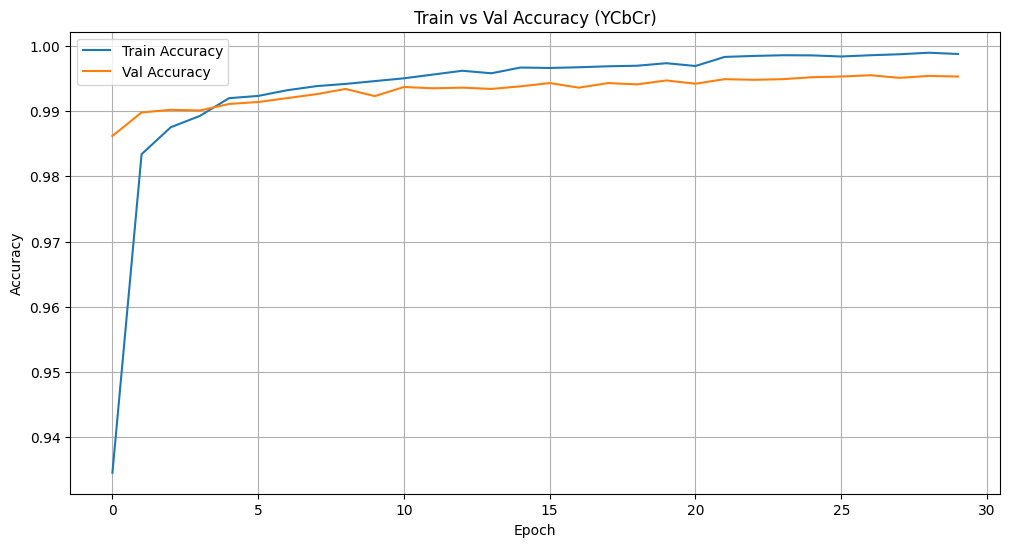

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9928 - loss: 0.4437
Test Loss (YCbCr): 0.4396, Test Accuracy (YCbCr): 0.9944
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


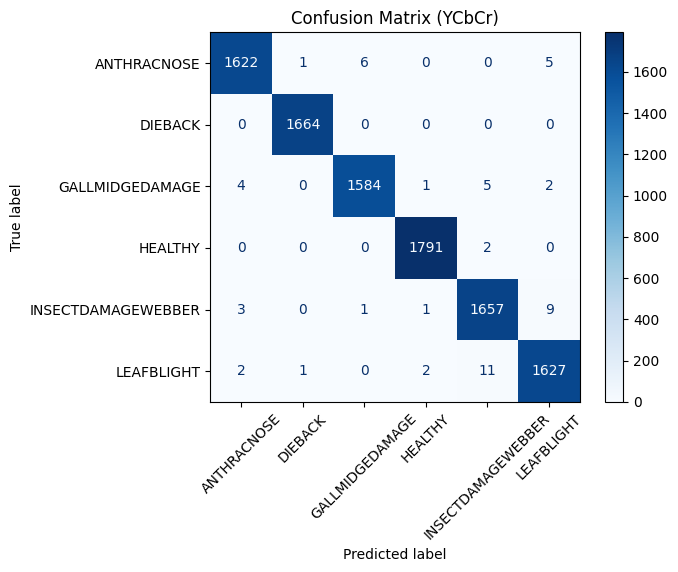

Classification Report (YCbCr):
                     precision    recall  f1-score   support

       ANTHRACNOSE     0.9945    0.9927    0.9936      1634
           DIEBACK     0.9988    1.0000    0.9994      1664
   GALLMIDGEDAMAGE     0.9956    0.9925    0.9940      1596
           HEALTHY     0.9978    0.9989    0.9983      1793
INSECTDAMAGEWEBBER     0.9893    0.9916    0.9904      1671
        LEAFBLIGHT     0.9903    0.9903    0.9903      1643

          accuracy                         0.9944     10001
         macro avg     0.9944    0.9943    0.9943     10001
      weighted avg     0.9944    0.9944    0.9944     10001



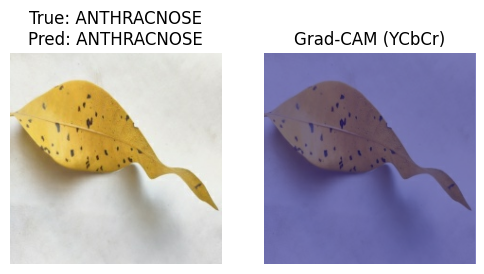

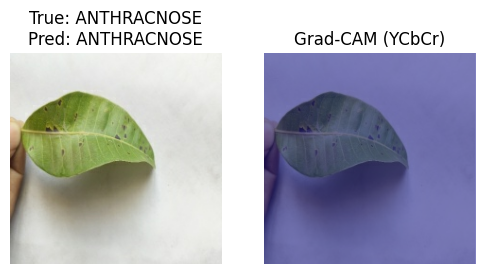

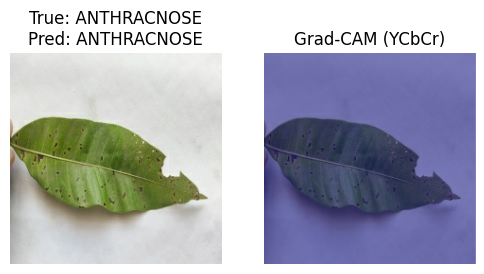

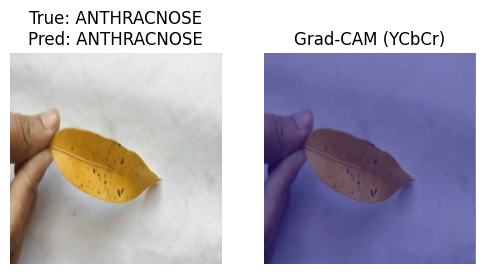

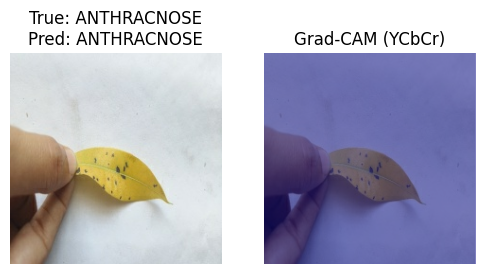

In [1]:
import tensorflow as tf
from transformers import ViTFeatureExtractor, TFAutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import cv2
import os

# ==========================================
# ✅ CONFIGURATION
# ==========================================
COLOR_SPACE = "YCbCr"  # Options: "RGB", "HSV", "LAB", "YCbCr"
img_size = (224, 224)
batch_size = 32
num_classes = 6

# ==========================================
# ✅ COLOR CONVERSION FUNCTION
# ==========================================
def convert_color_space(image_batch):
    image_batch = image_batch.astype(np.uint8)  # 🔁 Removed `.numpy()`
    converted_batch = []
    for img in image_batch:
        if COLOR_SPACE == "HSV":
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif COLOR_SPACE == "LAB":
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif COLOR_SPACE == "YCbCr":
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        converted_batch.append(img)
    return np.array(converted_batch)

# ==========================================
# ✅ LOAD ViT & FEATURE EXTRACTOR
# ==========================================
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_model = TFAutoModel.from_pretrained('google/vit-base-patch16-224')
vit_model.trainable = False

# ==========================================
# ✅ DATASET LOADING
# ==========================================
train_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/train'
val_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/val'
test_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/test'

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=img_size, batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=img_size, batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=img_size, batch_size=batch_size, shuffle=False)

class_names = train_ds.class_names

# ==========================================
# ✅ FEATURE EXTRACTION FUNCTION
# ==========================================
def extract_features(dataset):
    all_features, all_labels = [], []
    for batch_images, batch_labels in tqdm(dataset, desc=f"Extracting ViT features ({COLOR_SPACE})"):
        if COLOR_SPACE != "RGB":
            images_converted = tf.numpy_function(convert_color_space, [batch_images], tf.uint8)
            images_converted = tf.cast(images_converted, tf.uint8)
        else:
            images_converted = tf.image.convert_image_dtype(batch_images, dtype=tf.uint8)
        images_np = images_converted.numpy()
        pixel_values = feature_extractor(images_np, return_tensors='tf')['pixel_values']
        outputs = vit_model(pixel_values, training=False)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
        all_features.append(cls_embeddings.numpy())
        all_labels.append(batch_labels.numpy())
    features = np.vstack(all_features)
    labels = tf.keras.utils.to_categorical(np.concatenate(all_labels), num_classes)
    return features, labels

# ==========================================
# ✅ EXTRACT FEATURES
# ==========================================
X_train, y_train = extract_features(train_ds)
X_val, y_val = extract_features(val_ds)
X_test, y_test = extract_features(test_ds)

# ==========================================
# ✅ CLASSIFIER HEAD
# ==========================================
classifier = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

classifier.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint(f'best_vit_head_{COLOR_SPACE}.keras', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# ==========================================
# ✅ TRAINING
# ==========================================
history = classifier.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=callbacks)

# Save model
classifier.save(f'final_vit_head_model_{COLOR_SPACE}.keras')
classifier.save(f'final_vit_head_model_{COLOR_SPACE}.h5')

# Accuracy plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.grid(True)
plt.title(f'Train vs Val Accuracy ({COLOR_SPACE})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# ==========================================
# ✅ TEST RESULTS
# ==========================================
test_loss, test_acc = classifier.evaluate(X_test, y_test)
print(f"Test Loss ({COLOR_SPACE}): {test_loss:.4f}, Test Accuracy ({COLOR_SPACE}): {test_acc:.4f}")

# Confusion Matrix
y_pred_probs = classifier.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title(f"Confusion Matrix ({COLOR_SPACE})")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(f"Classification Report ({COLOR_SPACE}):\n", report)
with open(f"classification_report_vit_{COLOR_SPACE}.txt", "w") as f:
    f.write(report)

# ==========================================
# ✅ GRAD-CAM VISUALIZATION
# ==========================================
def preprocess_for_vit(img_batch):
    if COLOR_SPACE != "RGB":
        img_batch = tf.numpy_function(convert_color_space, [img_batch], tf.uint8)
    img_batch_uint8 = tf.image.convert_image_dtype(img_batch, dtype=tf.uint8)
    return feature_extractor(img_batch_uint8.numpy(), return_tensors='tf')['pixel_values']

def get_grad_cam_heatmap(image, classifier_model):
    with tf.GradientTape() as tape:
        pixel_values = preprocess_for_vit(image[None])[0]
        vit_out = vit_model(pixel_values[None], training=False).last_hidden_state  # shape: (1, 197, 768)
        cls_token = vit_out[:, 0, :]  # (1, 768)

        tape.watch(cls_token)
        preds = classifier_model(cls_token)
        top_class = tf.argmax(preds[0])
        top_output = preds[:, top_class]

    grads = tape.gradient(top_output, cls_token)
    pooled_grads = tf.reduce_mean(grads, axis=1)
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, cls_token), axis=1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()[0], int(top_class)

def display_gradcam(image, heatmap, true_label, pred_label, class_names):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(tf.cast(image, tf.uint8))
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(tf.cast(image, tf.uint8))
    plt.imshow(heatmap.reshape((1, 1)), cmap='jet', alpha=0.5, extent=(0, 224, 224, 0))
    plt.title(f"Grad-CAM ({COLOR_SPACE})")
    plt.axis("off")
    plt.show()

# ==========================================
# ✅ LOAD TEST IMAGES FOR VISUALIZATION
# ==========================================
raw_test_images, raw_labels = [], []
for batch_images, batch_labels in test_ds.take(1):
    raw_test_images.append(batch_images)
    raw_labels.append(batch_labels)

raw_test_images = tf.concat(raw_test_images, axis=0)
raw_labels = tf.concat(raw_labels, axis=0)

# ==========================================
# ✅ RUN GRAD-CAM FOR FIRST 5 IMAGES
# ==========================================
for i in range(5):
    image = raw_test_images[i]
    true_label = int(raw_labels[i])
    heatmap, pred_label = get_grad_cam_heatmap(image, classifier)
    display_gradcam(image, heatmap, true_label, pred_label, class_names)

